In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt
from libpysal.weights import Kernel
from scipy.spatial import distance_matrix

cf.go_offline()
data_dir = Path('../data/processed')
data = gpd.read_file(data_dir / 'spatial_income_1880.gpkg')
# print(data.loc[data.orthodox_proportion.isna()])
data = data.dropna().reset_index()
# W = Kernel.from_dataframe(data, fixed=True, bandwidth=150, function='quartic')
xy = np.array([data.geometry.x, data.geometry.y]).T
d = distance_matrix(xy, xy)
d_norm = d / d.max()
n = data.shape[0]

<AxesSubplot:>

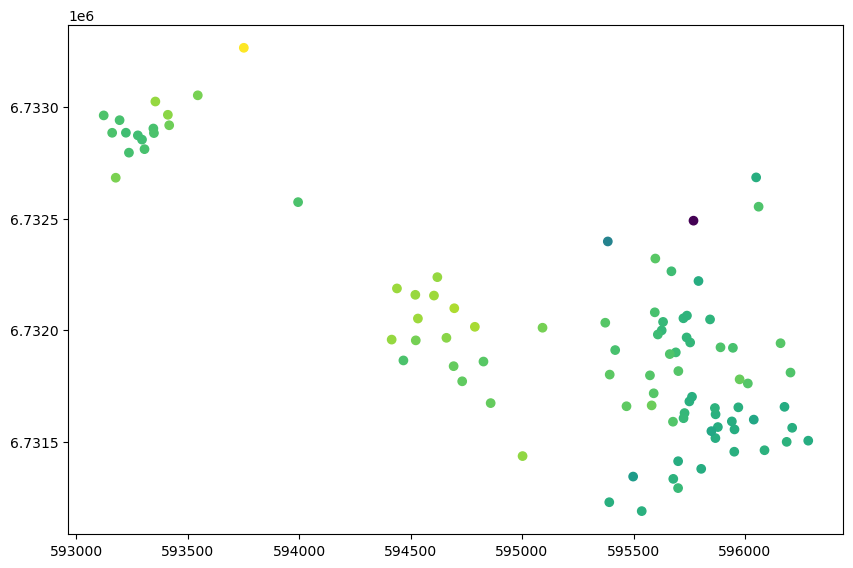

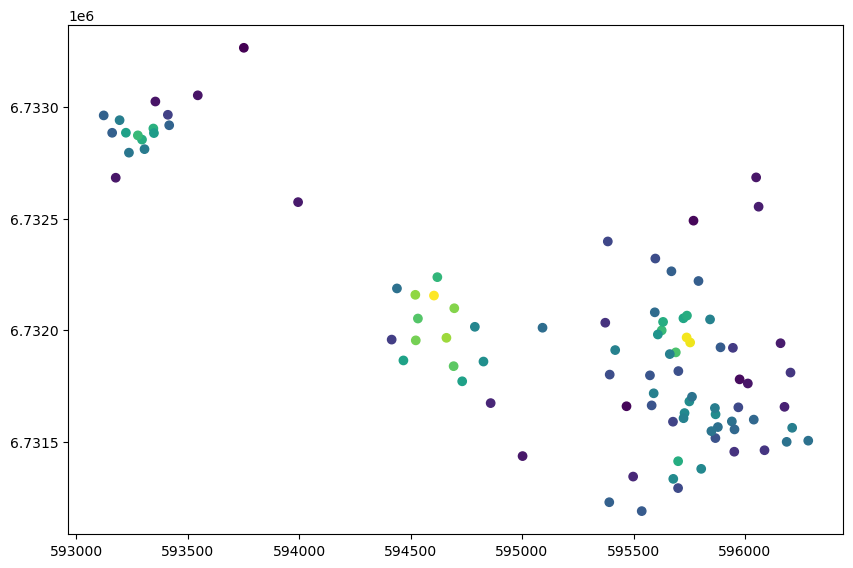

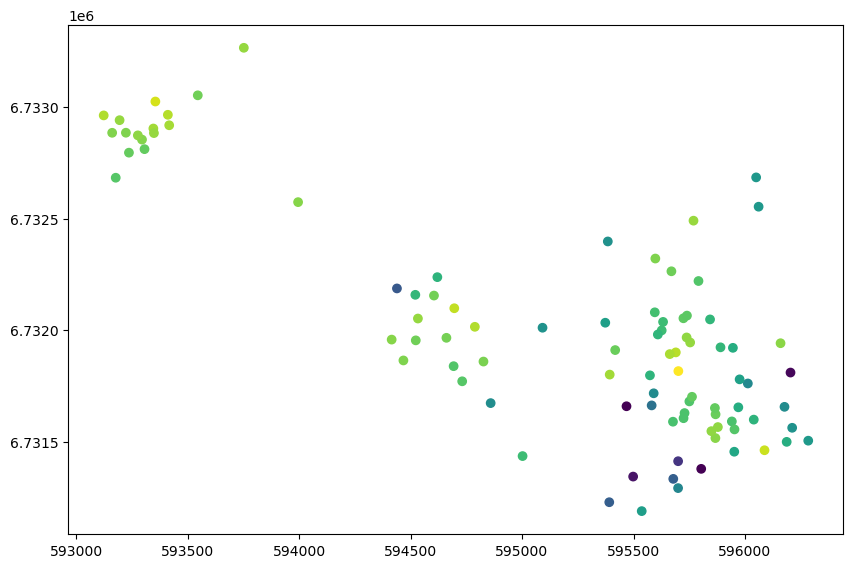

In [52]:
data.plot(column='income_per_capita_ln', figsize=(10,10))
data.plot(column='population', figsize=(10,10))
data.plot(column='orthodox_proportion_ln', figsize=(10,10))

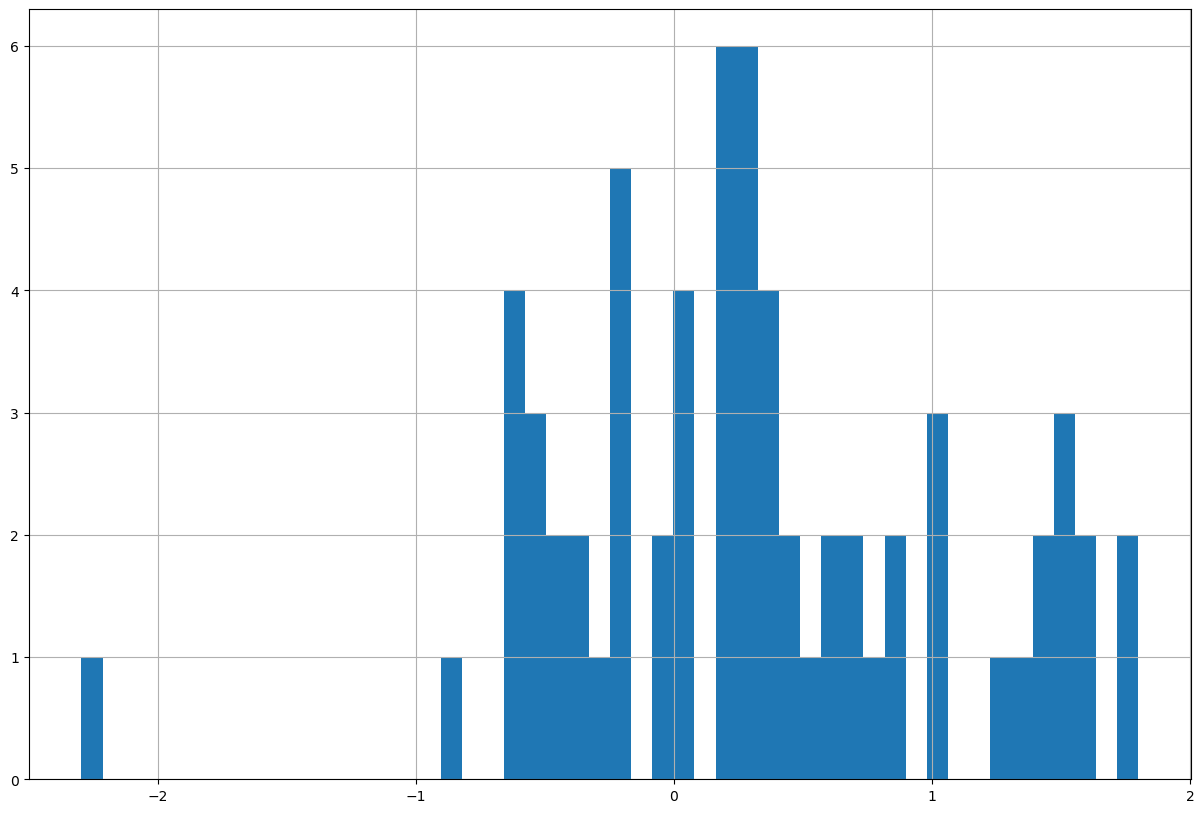

array([[<AxesSubplot:title={'center':'orthodox_proportion_ln'}>]],
      dtype=object)

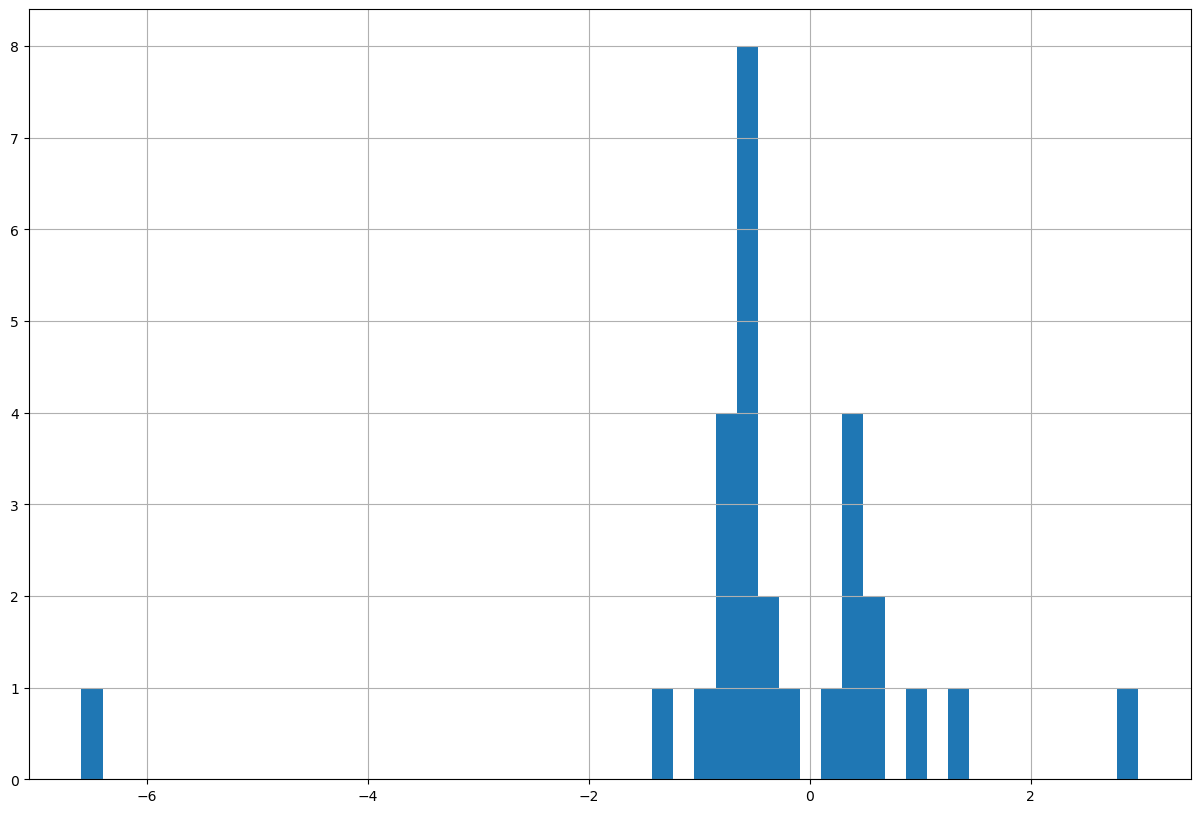

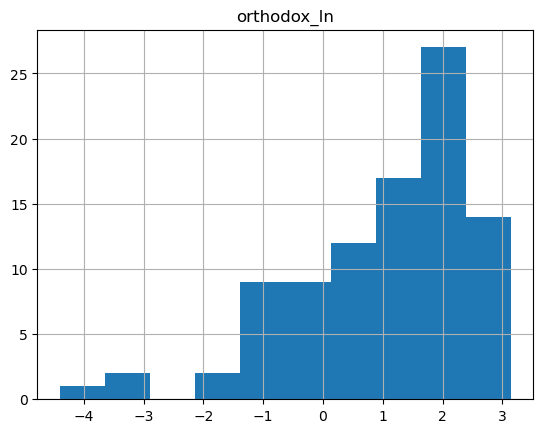

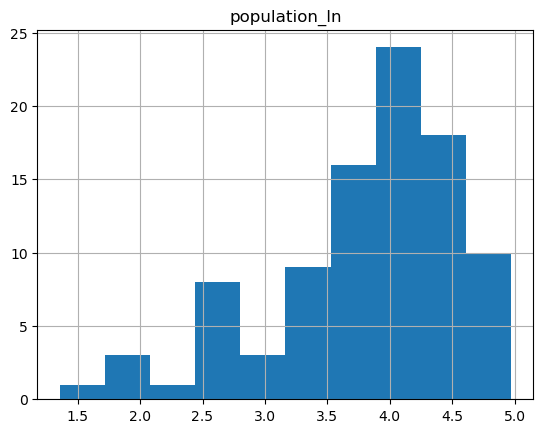

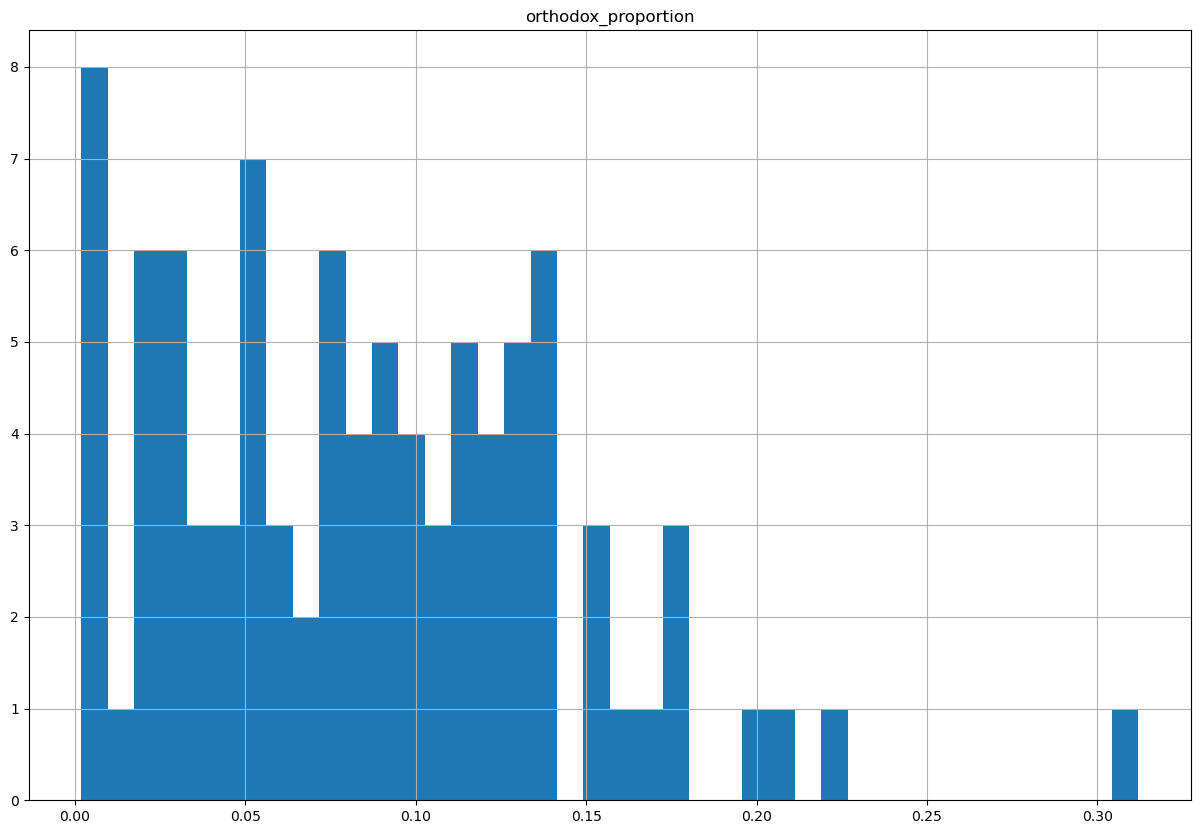

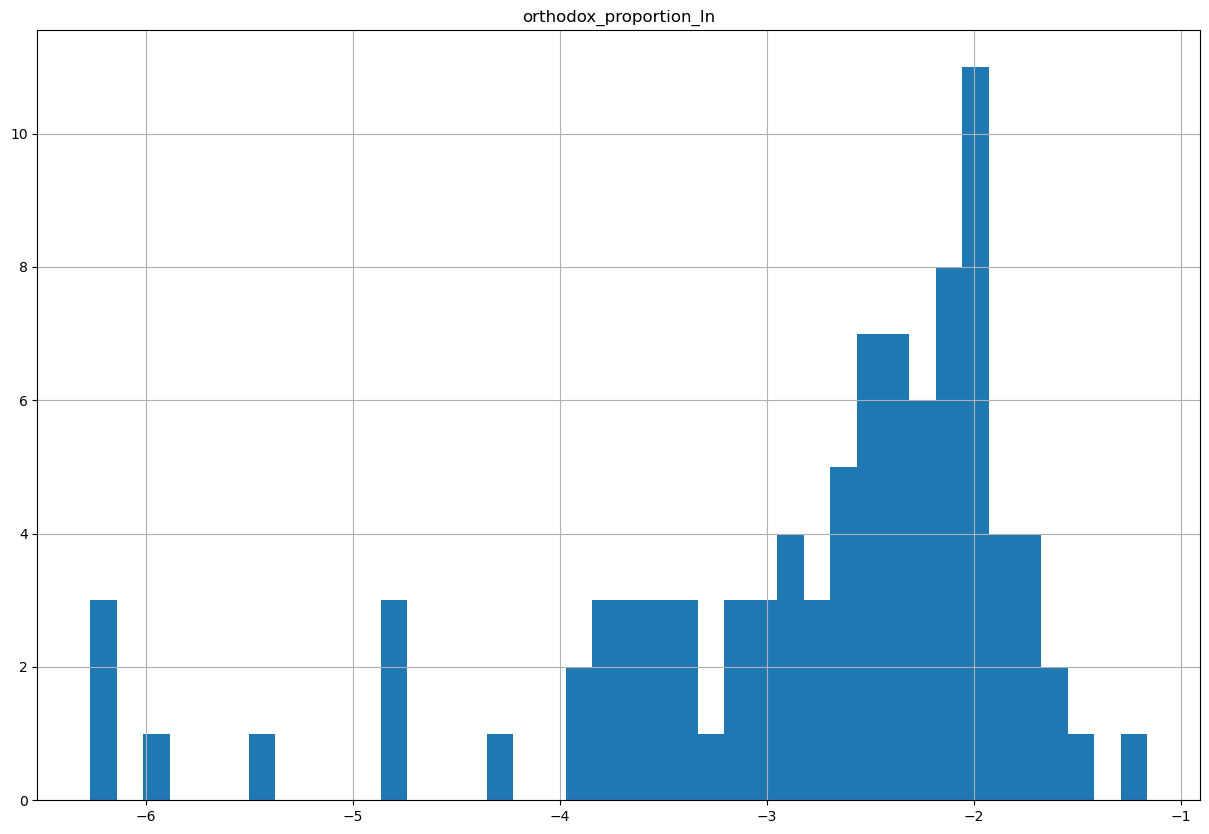

In [53]:
data.loc[data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
plt.show()
data.loc[~data.is_old,'income_per_capita'].hist(figsize=(15,10), bins=50)
data.hist(column='orthodox')
data.hist(column='population')
data.hist(column='orthodox_proportion', figsize=(15, 10), bins=40)
data.hist(column='orthodox_proportion_ln', figsize=(15, 10), bins=40)
# data.hist(column='orthodox')
# data.hist(column='lutheran')
# data.iplot(x='total_income', y='total_density', kind='scatter', mode='markers')

In [54]:
# with pm.Model() as model_1:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O = np.array([0., 0., 0.])
#     mu_beta_L = np.array([0., 0., 0.])
#     sigma_beta_O = np.array(np.diagflat([0.25, 0.25, 0.25]))
#     sigma_beta_L = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O = pm.MvNormal('beta_O', mu_beta_O, sigma_beta_O, shape=3)
#     beta_L = pm.MvNormal('beta_L', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O = pm.HalfNormal('sigma_O', 10)
#     sigma_L = pm.HalfNormal('sigma_L', 10)
#
#     O = pm.Normal('O', beta_O[0] + beta_O[1] * F + beta_O[2] * ln_W, sigma_O, observed=data.orthodox)
#     L = pm.Normal('L', beta_L[0] + beta_L[1] * F + beta_L[2] * ln_W, sigma_L, observed=data.lutheran)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_1)

In [55]:
# with pm.Model() as model_2:
#     F = pm.ConstantData('F', data.is_old.astype('int'))
#
#     mu_beta_W = np.array([4, 1])
#     sigma_beta_W = np.array(np.diagflat([1, 1]))
#     beta_W = pm.MvNormal('beta_W', mu_beta_W, sigma_beta_W, shape=2)
#     sigma_W = pm.HalfNormal('sigma_W', sigma=1)
#     ln_W = pm.StudentT('ln_W', nu=1, mu=beta_W[0] + beta_W[1] * F, sigma=sigma_W, observed=data.total_income_ln)
#
#     mu_beta_O_prop = np.array([0.1, 0.1, 0.1])
#     mu_beta_P = np.array([0., 0., 0.])
#     sigma_beta_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))
#     sigma_beta_P = np.array(np.diagflat([0.25, 0.25, 0.25]))
#
#     beta_O_prop = pm.MvNormal('beta_O_prop', mu_beta_O_prop, sigma_beta_O_prop, shape=3)
#     beta_P = pm.MvNormal('beta_P', mu_beta_L, sigma_beta_L, shape=3)
#     sigma_O_prop = pm.HalfNormal('sigma_O_prop', 0.05)
#     sigma_P = pm.HalfNormal('sigma_P', 50)
#     P = pm.Normal('P', beta_P[0] + beta_P[1] * F + beta_P[2] * ln_W, sigma_P, observed=data.population)
#
#     mu_O_prop = beta_O_prop[0] + beta_O_prop[1] * F + beta_O_prop[2] * ln_W
#     O_prop = pm.TruncatedNormal('O_prop', mu=mu_O_prop, sigma=sigma_O_prop, lower=0, upper=1, observed=data.orthodox_proportion)
#
#     prior = pm.sample_prior_predictive()
#     posterior = pm.sample(init="adapt_diag", return_inferencedata=True)
#     posterior_prediction = pm.sample_posterior_predictive(posterior)
#
# az.plot_posterior(posterior)
# az.plot_trace(posterior)
# az.plot_forest(posterior, combined=False, hdi_prob=0.94)
# pm.model_to_graphviz(model_2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_O, β_P, σ_O, σ_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


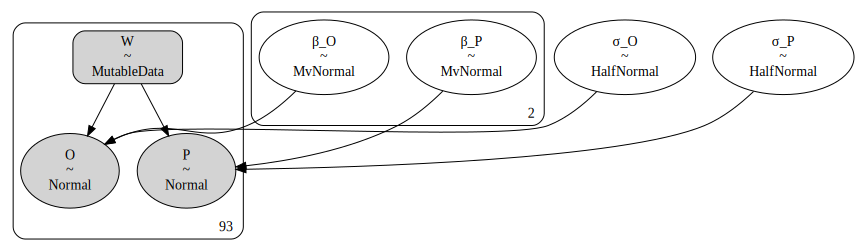

In [56]:
with pm.Model() as model_1:
    W = pm.MutableData('W', data.income_per_capita_ln)

    mu_β_O_prop = np.array([0, 0])
    σ_β_O_prop = np.array(np.diagflat([0.1, 0.1]))

    mu_β_P = np.array([0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1]))

    β_O_prop = pm.MvNormal('β_O', mu_β_O_prop, σ_β_O_prop, shape=2)
    β_P = pm.MvNormal('β_P', mu_β_P, σ_β_P, shape=2)
    σ_O_prop = pm.HalfNormal('σ_O', 0.1)
    σ_P = pm.HalfNormal('σ_P', 0.1)

    P = pm.Normal('P', β_P[0] + β_P[1] * W, σ_P, observed=data.population_ln)

    mu_O_prop = β_O_prop[0] + β_O_prop[1] * W
    O_prop = pm.Normal('O', mu_O_prop, σ_O_prop, observed=data.orthodox_proportion_ln)

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

graph_1 = pm.model_to_graphviz(model_1)
graph_1

array([<AxesSubplot:xlabel='P / P'>, <AxesSubplot:xlabel='O / O'>],
      dtype=object)

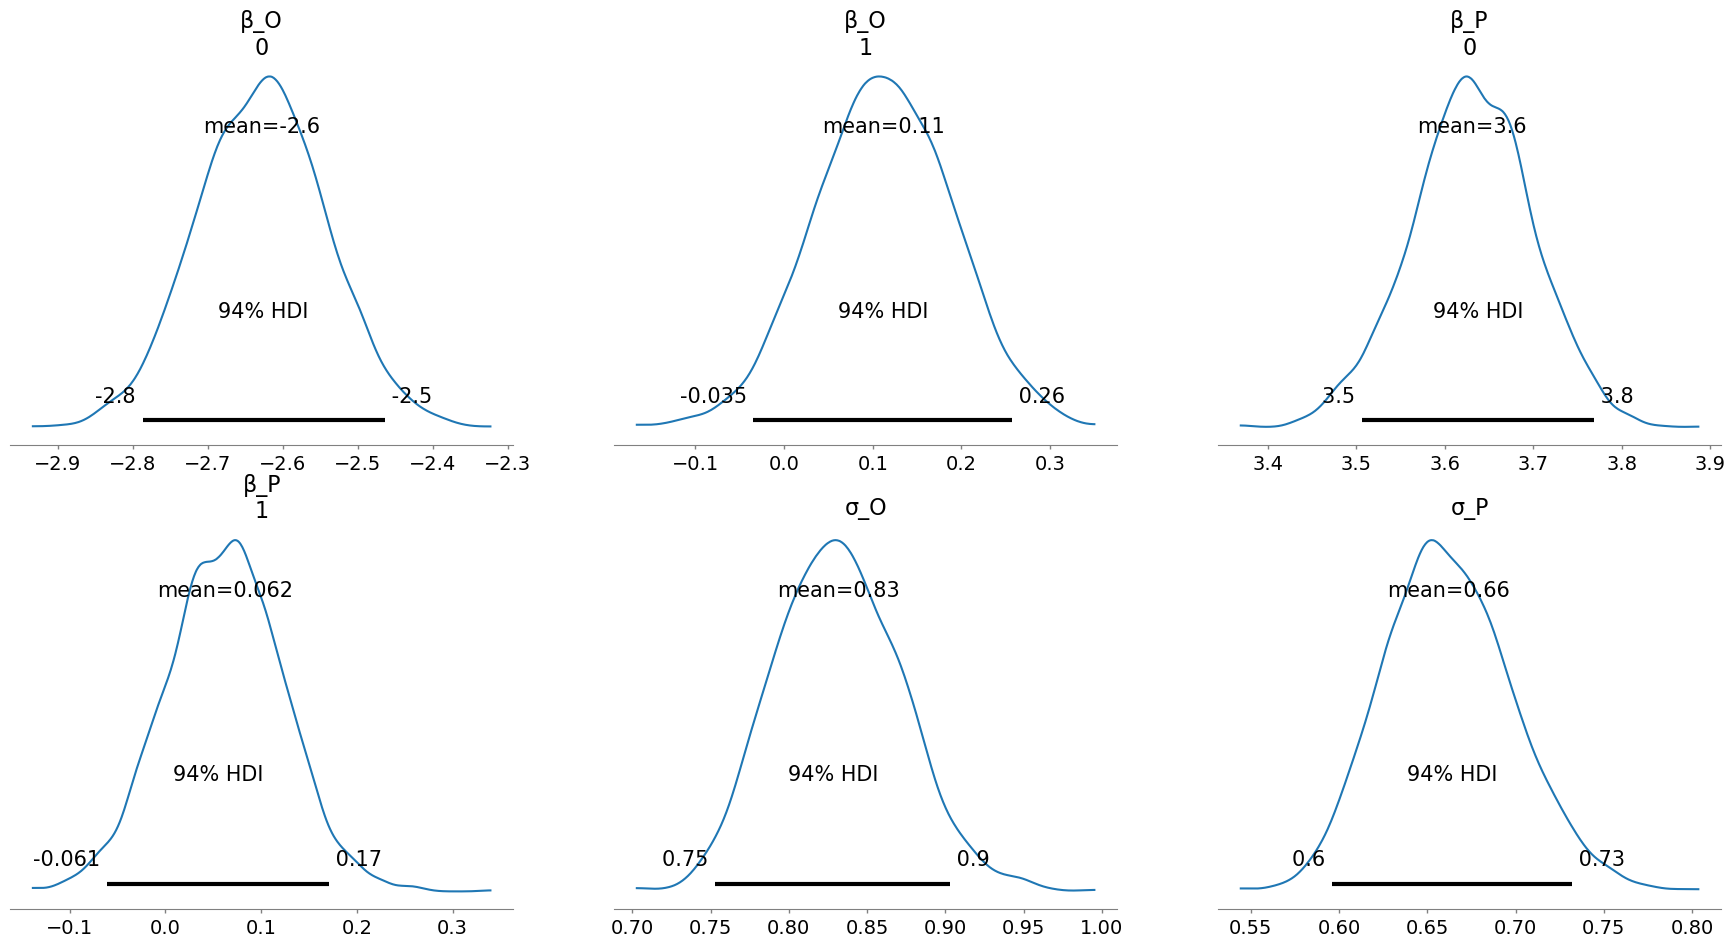

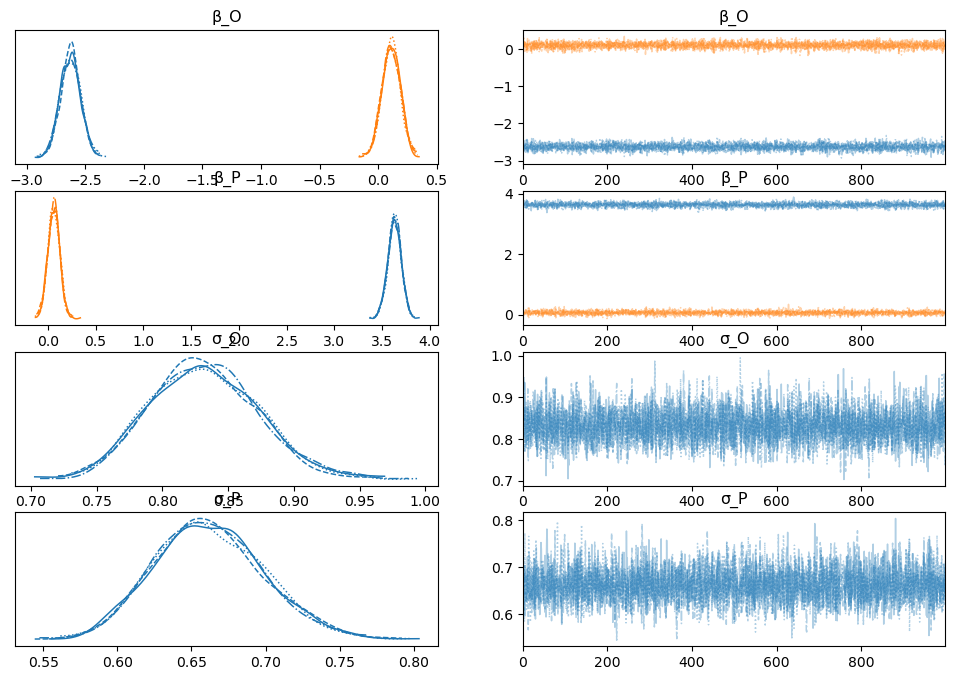

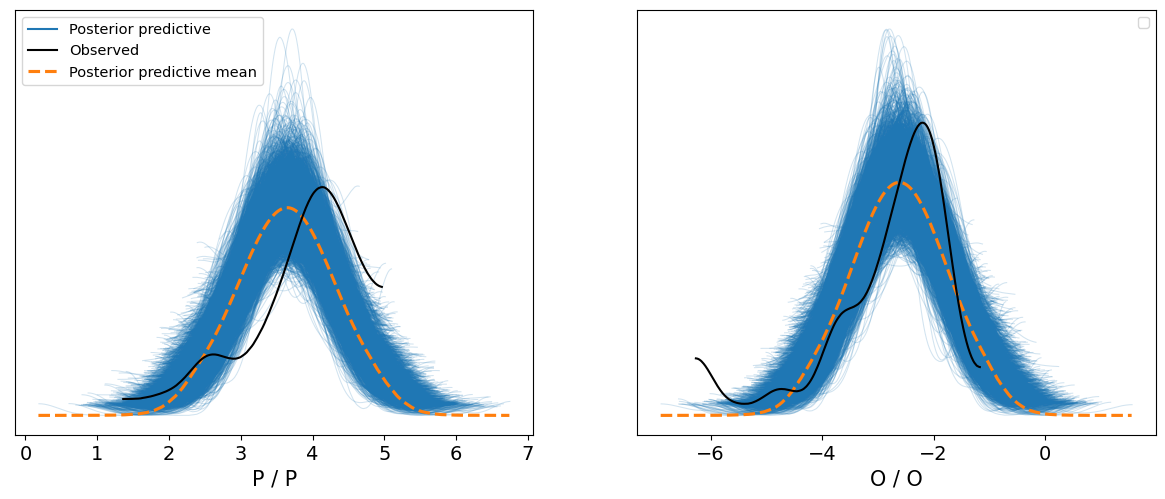

In [57]:
az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
# az.plot_forest(posterior_1, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_W, σ_W, β_O, β_P, σ_O, σ_P]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


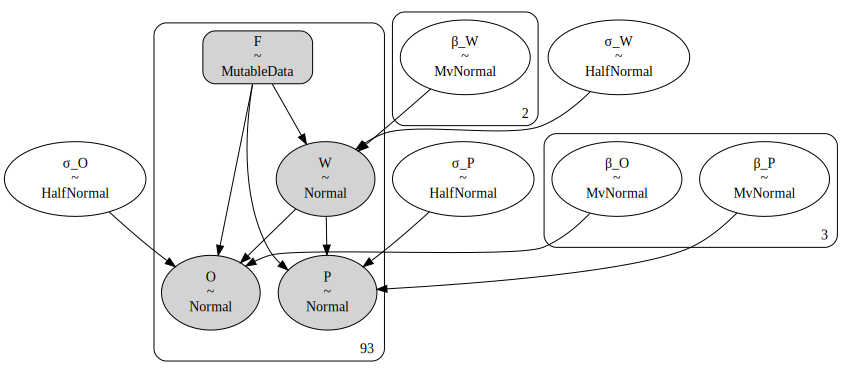

In [58]:
with pm.Model() as model_2:
    F = pm.MutableData('F', data.is_old.astype('int'))

    mu_β_W = np.array([0, 0])
    σ_β_W = np.array(np.diagflat([1, 1]))
    β_W = pm.MvNormal('β_W', mu_β_W, σ_β_W, shape=2)
    σ_W = pm.HalfNormal('σ_W', 1)
    W = pm.Normal('W', β_W[0] + β_W[1] * F, σ_W, observed=data.income_per_capita_ln)

    mu_β_O_prop = np.array([0, 0, 0])
    σ_β_O_prop = np.array(np.diagflat([0.1, 0.1, 0.1]))

    mu_β_P = np.array([0., 0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1, 0.1]))

    β_O_prop = pm.MvNormal('β_O', mu_β_O_prop, σ_β_O_prop, shape=3)
    β_P = pm.MvNormal('β_P', mu_β_P, σ_β_P, shape=3)
    σ_O_prop = pm.HalfNormal('σ_O', 0.1)
    σ_P = pm.HalfNormal('σ_P', 0.1)

    P = pm.Normal('P', β_P[0] + β_P[1] * F + β_P[2] * W, σ_P, observed=data.population_ln)

    mu_O_prop = β_O_prop[0] + β_O_prop[1] * F + β_O_prop[2] * W
    O_prop = pm.Normal('O', mu_O_prop, σ_O_prop, observed=data.orthodox_proportion_ln)

    prior_2 = pm.sample_prior_predictive()
    posterior_2 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_2 = pm.sample_posterior_predictive(posterior_2)

graph_2 = pm.model_to_graphviz(model_2)
graph_2

array([<AxesSubplot:xlabel='W / W'>, <AxesSubplot:xlabel='P / P'>,
       <AxesSubplot:xlabel='O / O'>], dtype=object)

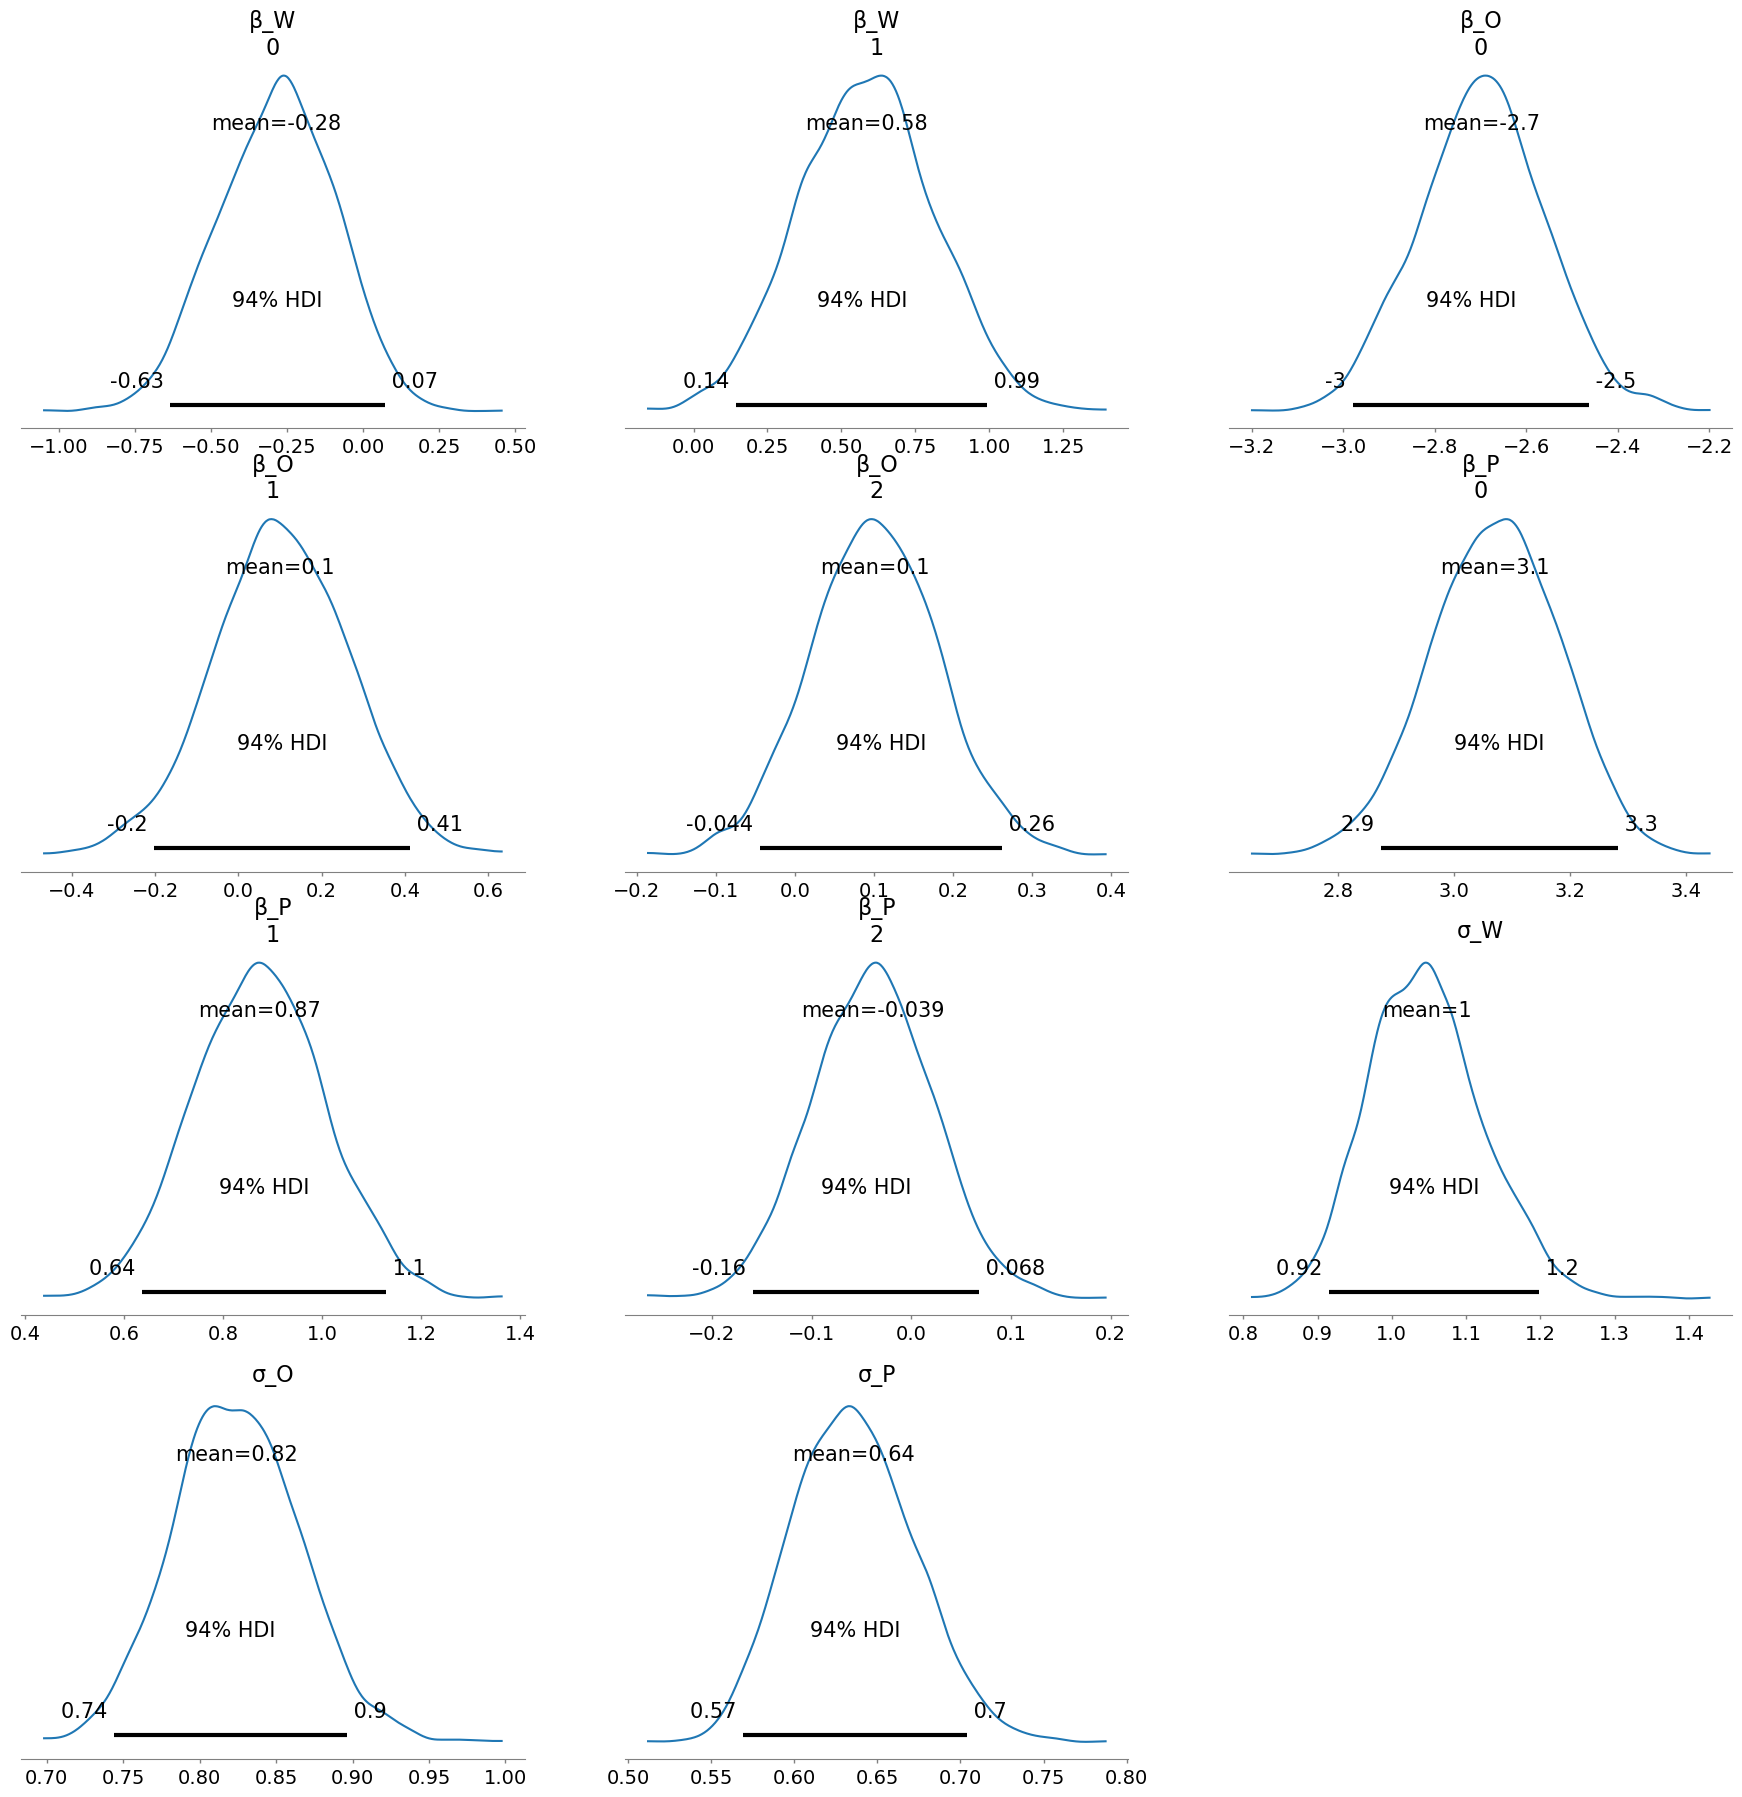

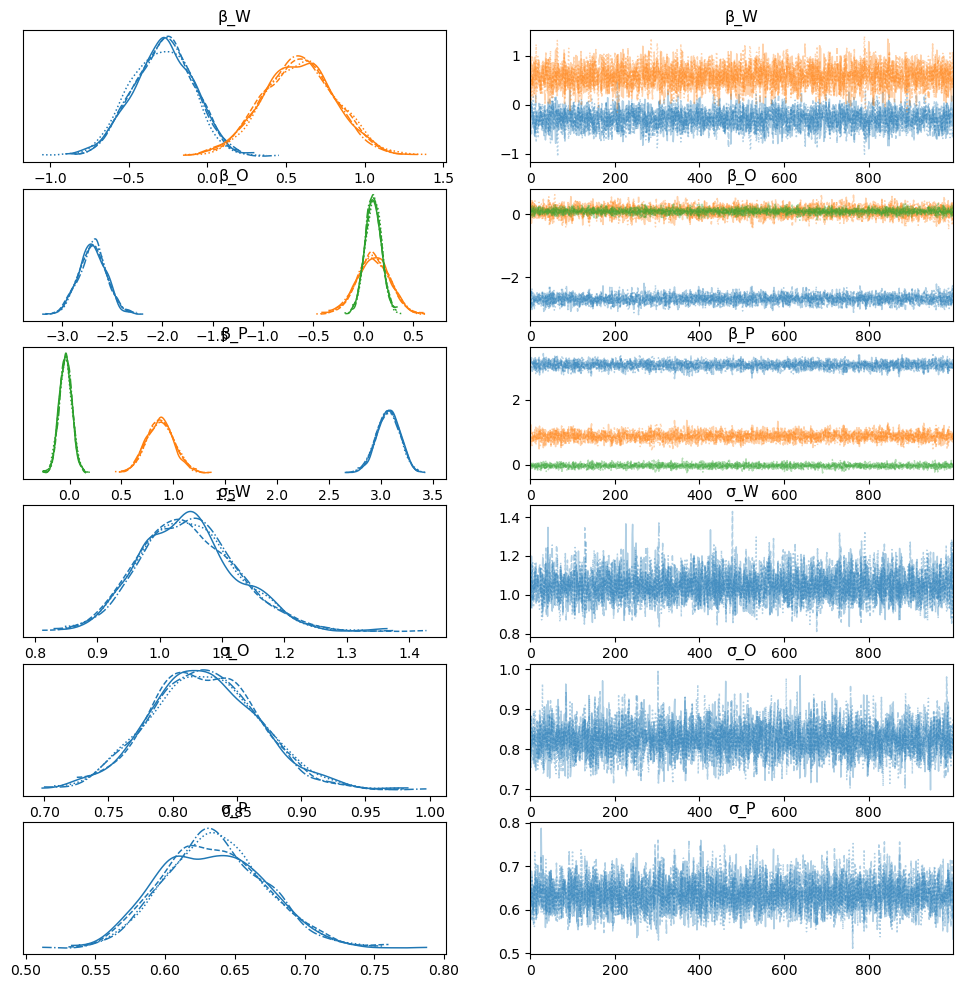

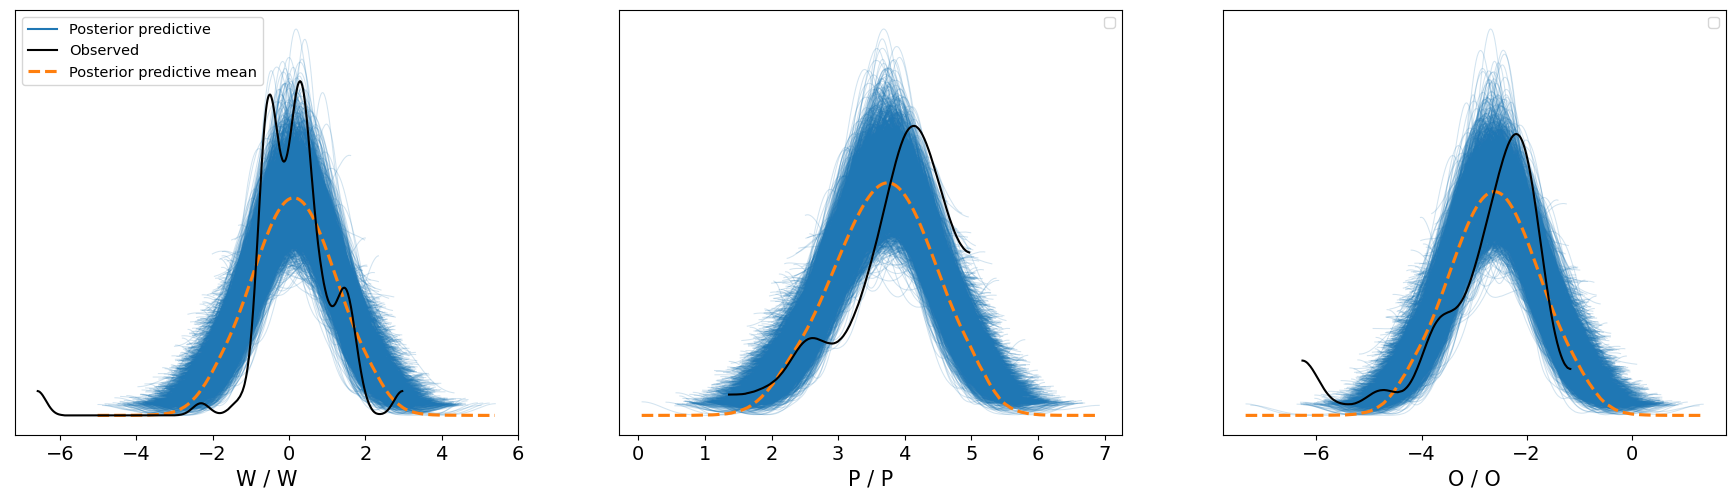

In [59]:
az.plot_posterior(posterior_2)
az.plot_trace(posterior_2)
# az.plot_forest(posterior_2, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_2)

<AxesSubplot:>

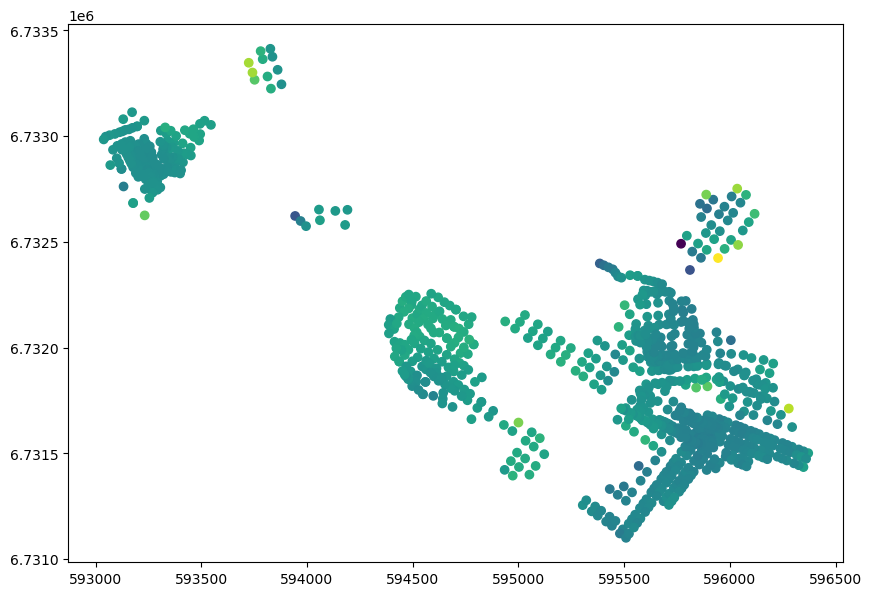

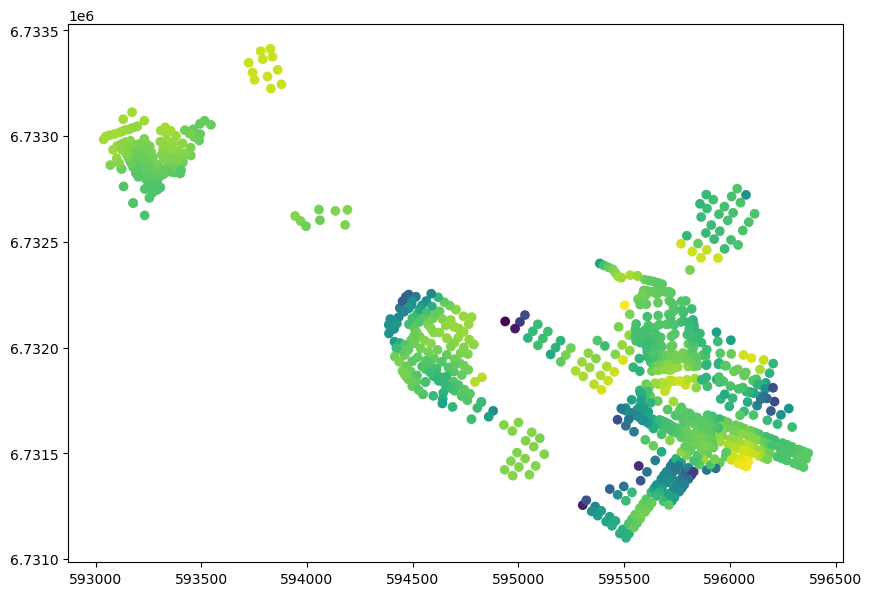

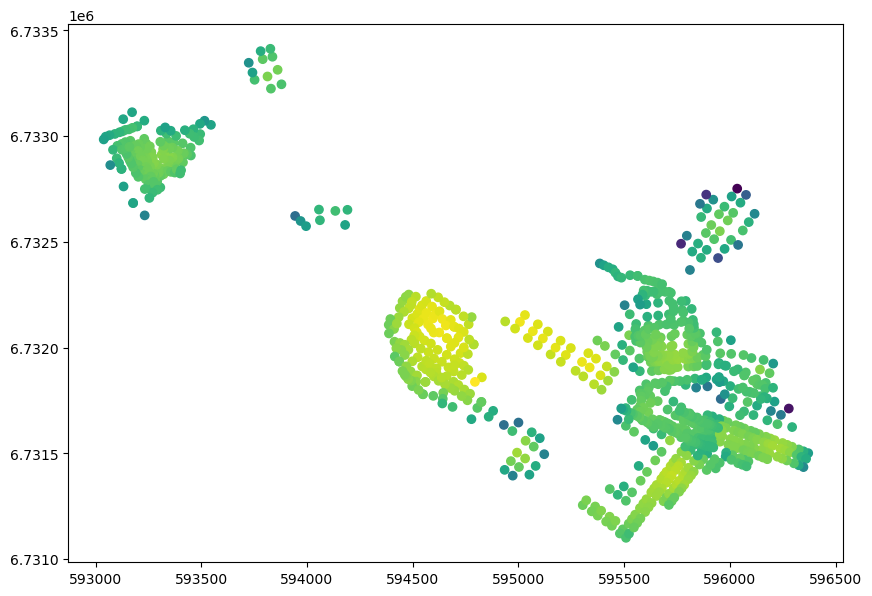

In [2]:
# Residuals

data['W_residual'] = data.income_per_capita_ln - 0.31 * data.is_old
data.plot(column='W_residual', figsize=(10, 10))

data['O_residual'] = data.orthodox_proportion_ln - (-3.4 + 0.94 * data.is_old)
data.plot(column='O_residual', figsize=(10, 10))

data['P_residual'] = data.population_ln - (3.1 + data.is_old - 0.49 * data.income_per_capita_ln)
data.plot(column='P_residual', figsize=(10, 10))

In [ ]:
with pm.Model() as model_3:
    F = pm.MutableData('F', data.is_old.astype('int'))
    idx = data.index.values

    η = pm.Exponential('η_W', 0.5)
    ρ = pm.Exponential('ρ_W', 0.5)
    K = η * pm.gp.cov.ExpQuad(1, ls=ρ)

    μ_β_W = np.array([0, 0])
    σ_β_W = np.array(np.diagflat([1, 1]))
    β_W = pm.MvNormal('β_W', μ_β_W, σ_β_W, shape=2)

    σ_W = pm.Exponential('σ_W', 0.1)
    σ_O = pm.Exponential('σ_O', 0.1)
    σ_P = pm.Exponential('σ_P', 0.1)

    ε_W = pm.gp.Latent(cov_func=K).prior('ε_W', X=d_norm)
    W = pm.Normal('W', β_W[0] + β_W[1] * F + ε_W[idx], σ_W, observed=data.income_per_capita_ln)

    μ_β_O = np.array([0, 0, 0])
    σ_β_O = np.array(np.diagflat([0.1, 0.1, 0.1]))

    μ_β_P = np.array([0., 0., 0.])
    σ_β_P = np.array(np.diagflat([0.1, 0.1, 0.1]))

    β_O = pm.MvNormal('β_O', μ_β_O, σ_β_O, shape=3)
    β_P = pm.MvNormal('β_P', μ_β_P, σ_β_P, shape=3)

    ε_O = pm.gp.Latent(cov_func=K).prior('ε_O', X=d_norm)
    O = pm.Normal('O', β_O[0] + β_O[1] * F + β_O[2] * W + ε_O[idx], σ_O, observed=data.orthodox_proportion_ln)

    ε_P = pm.gp.Latent(cov_func=K).prior('ε_P', X=d_norm)
    P = pm.Normal('P', β_P[0] + β_P[1] * F + β_P[2] * W + ε_P[idx], σ_P, observed=data.population_ln)

    prior_3 = pm.sample_prior_predictive()
    posterior_3 = pm.sample(draws=100, tune=100, init="adapt_diag", return_inferencedata=True, target_accept=0.9)
    posterior_prediction_3 = pm.sample_posterior_predictive(posterior_3)

graph_3 = pm.model_to_graphviz(model_3)
graph_3

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/pymc/gp/cov.py:99: UserWarning:

Only 1 column(s) out of 926 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [η_W, ρ_W, β_W, σ_W, σ_O, σ_P, ε_W_rotated_, β_O, β_P, ε_O_rotated_, ε_P_rotated_]


In [ ]:
az.plot_posterior(posterior_3)
# az.plot_trace(posterior_3)
az.plot_forest(posterior_3, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_3)